# Tutorial for the mag_calc python module

## Table of Contents

1. MagCalc
1. calculate_field(s)
1. find_field
1. make_plane

## Imports

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits  import mplot3d
from time import time
from mag_calc import MagCalc

%matplotlib inline

## MagCalc

First we import and create an instance of **MagCalc**.

Notice, 'atoms.npy' and 'spins.npy' are atom positions and spin directions from MnO.

In [3]:
atoms = np.load('files/MnO_atoms.npy')
spins = np.load('files/MnO_spins.npy')

atoms and spins are numpy arrays, each having 3 columns specifying $x,y,z$ location coordinates or $i,j,k$ spin directions respectively

In [4]:
atoms.shape

(10149, 3)

The equation for the magnetic dipole moment is

$\mu = g\mu_Bs$   (or possible $\mu_N$)

To instantiate **MagCalc** we need 3 more values to calculate spin magnitude.

1. The g-factor
1. Which magneton to use
1. The spin value

For MnO we have $2$, $\mu_B$, and $0.5$ respectively

In [7]:
calc = MagCalc(atoms=atoms, 
               spins=spins, 
               g_factor=2, 
               spin=.5, 
               magneton='mu_B')

In [8]:
print(calc)

atoms shape:	 (10149, 3)
spins shape:	 (10149, 3)
locations:	 None
g_factor:	 2
spin:		 0.5
magneton:	 mu_B


## calculate_field(s)

One of the primary uses of **MagCalc** is to calculate the magnetic field at any point inside the crystal lattice. This is done using the following formula:

\begin{equation*}
\frac{\mu_0}{4\pi} \frac{3\hat{r} (\hat{r} \cdot m) - m}{|r|^3}
\end{equation*}

In [14]:
location = np.random.rand(3)
locations = np.random.rand(100,3)

If we want to calculate the field at one single location we use **calculate_field**. The argument **return_vector** specifies if we want the magnitude of the field or the vector.

In [19]:
field = calc.calculate_field(location=location, 
                             return_vector=True)
field

array([-2.84171617, -0.63802208, -0.68853566])

To calculate the field at multiple locations use **calculate_fields**. The argument **mask_radius** specifies the radius in angstroms of which atoms to include in the calculations. If the number of locations is greater that 30, it speeds up the calculation. A radius of 8 or greater generally maintains accuracy.

In [21]:
fields = calc.calculate_fields(locations=locations,
                               return_vector=False,
                               mask_radius=8)
fields.mean()

6.033936590923841

Here is a 2D visualization of how **mask_radius** works. In this situation, only the green atoms would be included in the calculation at the center of the circle.
![SegmentLocal](tutorial/mask.gif "segment")

## find_field

If we want to find the location of a magnetic field (in Teslas) we can use **find_field**.

In [22]:
field = 1.0

The argument **center_point** specifies at which point to start the search, and the argument **search_range** specifies the radius in Angstroms to limit the search.

In [31]:
location = calc.find_field(field=field,
                           center_point=np.zeros(3),
                           search_range=10)
location

array([ 1.79220625,  3.0513736 , -1.99542103])

To verify the location is actually 1 Tesla:

In [32]:
calc.calculate_field(location, False)

0.9999999933693255

## make_plane

Another useful method of **MagCalc** is the ability to calculate the magnetic field over an evenly spaced plane. This is especially useful for visualization, as we show below. 

Note: Running the below cell will take almost a minute.

In [62]:
start = time()
plane = calc.make_plane(side_length=10,
                        resolution=40,
                        center_point=np.random.rand(3),
                        norm_vec=np.random.rand(3),
                        return_vector=False,
                        mask_radius=8)
print('Runtime: ', time() - start)

Runtime:  55.00501036643982


Below we make a visual of the plane we just calculated.

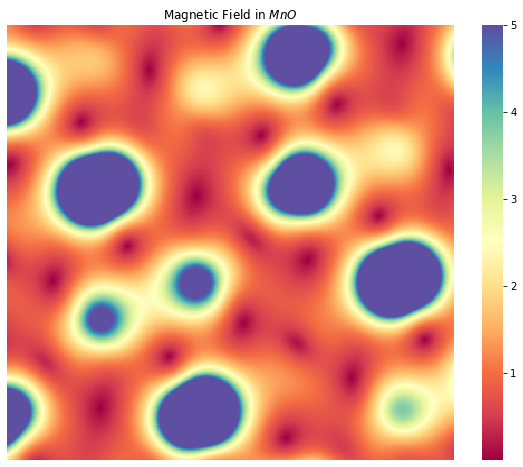

In [63]:
sns.heatmap(plane, cmap='Spectral', vmax=5)
plt.axis('off')
plt.gcf().set_size_inches(10,8)
plt.title('Magnetic Field in $MnO$')
plt.show()

A description of the new arguments is given below:
1. **side_length**: The side length of the plane in Angstroms
1. **resolution**: The number of measurements per Angstrom
1. **center_point**: The center point of the plane
1. **norm_vec**: The vector normal to the coordinate plane we want. (visual below)

In the below visualization **norm_vec** would be the vector **not** lying in the plane.
![SegmentLocal](tutorial/basis.gif "segment")

Some other cool visuals made with **make_plane**.

Runtime:  28.435463428497314


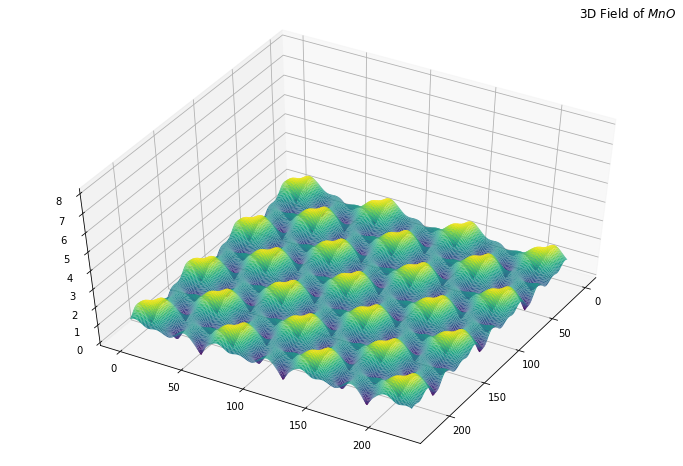

In [57]:
resolution = 15
side_length = 15
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,1]))
print('Runtime: ', time() - start)
with np.nditer(plane, op_flags=['readwrite']) as it:
    for x in it:
        if x > 15: x[...] = 15

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.plot_surface(A, B, plane, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_zlim(0, plane.max()*4)
ax.view_init(50, 30)

plt.gcf().set_size_inches(12,8)
plt.title('3D Field of $MnO$', loc='right')

plt.show()

Runtime:  2.6210196018218994


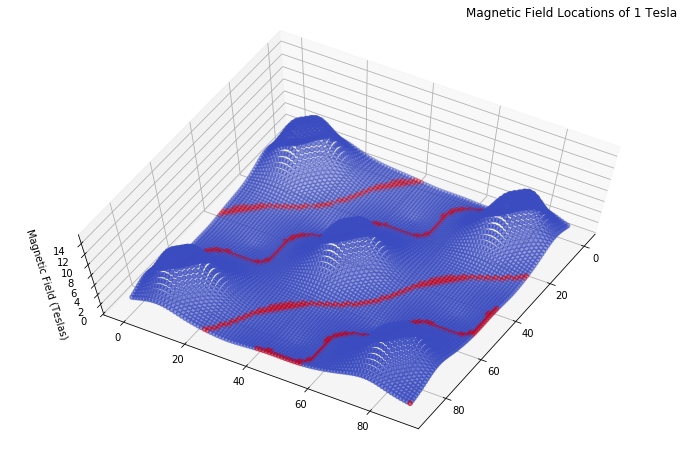

In [64]:
resolution = 15
side_length = 6
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.6]))
print('Runtime: ', time() - start)

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.scatter(A, B, plane, c=mask.ravel(), cmap='coolwarm', linewidth=1.2)

ax.set_zlim(0, plane.max()*1.5)
ax.view_init(70, 30)
plt.gcf().set_size_inches(12,8)
plt.title('Magnetic Field Locations of 1 Tesla', loc='right')
ax.set_zlabel('Magnetic Field (Teslas)')
plt.show()

Runtime:  6.0445661544799805


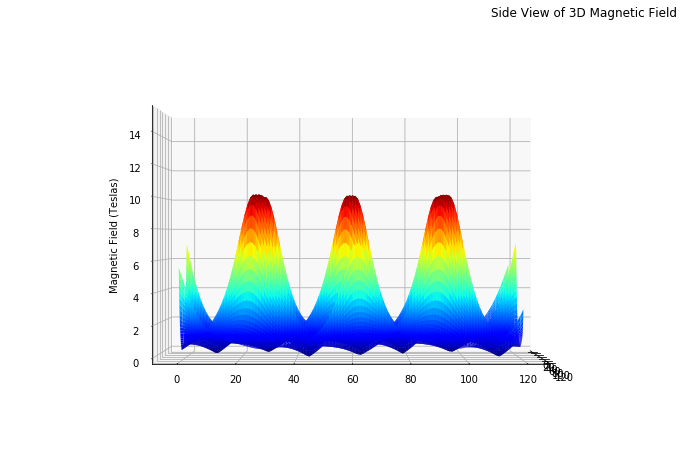

In [66]:
resolution = 15
side_length = 8
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.6]))
print('Runtime: ', time() - start)

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.plot_surface(A, B, plane, rstride=1, cstride=1,
                cmap='jet', edgecolor='none')

ax.set_zlim(0, plane.max()*1.5)
ax.view_init(0, 0)
plt.gcf().set_size_inches(12,8)
plt.title('Side View of 3D Magnetic Field', loc='right')
ax.set_zlabel('Magnetic Field (Teslas)')
plt.show()